In [18]:
pip install -q sagemaker-experiments matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
%matplotlib inline

In [7]:
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name

bucket = sess.default_bucket()
prefix = 'module_4/part_7'

print(role)
print(sess)
print(region)
print(bucket)
print(prefix)

arn:aws:iam::467432373215:role/service-role/AmazonSageMaker-ExecutionRole-20221206T164397
eu-west-1
sagemaker-eu-west-1-467432373215
module_4/part_7


In [8]:
from sagemaker.tensorflow import TensorFlow

In [7]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from botocore.exceptions import ClientError
from time import gmtime, strftime
import time

experiment_name = 'fashion-mnist-tensorflow'

try:
    experiment = Experiment.create(
        experiment_name=experiment_name, 
        description='Training a fashion mnist model')
except ClientError as e:
    print(f'{experiment_name} experiment already exists! Reusing the existing experiment.')


In [10]:
hyperparameters = {
    "epochs": 20, 
    "batch-size": 64
}

estimator = TensorFlow(
    entry_point="fashion_mnist_tensoflow.py",
    source_dir="tf_code",
    enable_sagemaker_metrics=True,
    hyperparameters=hyperparameters,
    role=role,
    input_mode='File',
    framework_version="2.1",
    py_version="py3",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    model_dir=False
)

In [11]:
# Creating a new trial for the experiment
exp_datetime = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'fashion-tf-{exp_datetime}'

exp_trial = Trial.create(experiment_name=experiment_name, 
                         trial_name=jobname)

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial.trial_name,
                   'TrialComponentDisplayName': 'Training'}

In [12]:
estimator.fit(job_name=jobname,
              experiment_config=experiment_config,
              logs=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: fashion-tf-2022-12-12-22-02-39


2022-12-12 22:02:40 Starting - Starting the training job...
2022-12-12 22:03:04 Starting - Preparing the instances for trainingProfilerReport-1670882560: InProgress
......
2022-12-12 22:04:04 Downloading - Downloading input data
2022-12-12 22:04:04 Training - Downloading the training image......
2022-12-12 22:05:05 Training - Training image download completed. Training in progress.2022-12-12 22:04:59,393 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-12-12 22:04:59,400 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-12 22:04:59,569 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-12 22:04:59,585 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-12 22:04:59,601 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-12 22:04:59,614 sagemaker-training-toolkit INFO     Invoking 

###  Descargando y usando el modelo localmente

In [26]:
estimator.model_data

's3://sagemaker-eu-west-1-467432373215/fashion-mnist-tensorflow-2-2022-12-12-21-24-55-580/output/model.tar.gz'

In [9]:
!mkdir ./fashion_mnist -p
!aws s3 cp {estimator.model_data} ./fashion_mnist/model.tar.gz
!tar -xzf fashion_mnist/model.tar.gz -C ./fashion_mnist/

download: s3://sagemaker-eu-west-1-467432373215/fashion-mnist-tensorflow-2022-12-12-20-14-55-373/output/model.tar.gz to fashion_mnist/model.tar.gz
tar: fashion_mnist/model: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [19]:
import tensorflow as tf
my_model=tf.keras.models.load_model('./fashion_mnist/00000000')

In [20]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


## Optimización de parámetros / arquitectura

- Usaremos el  script de entrenamiento fashion_mnist_tensoflow_opt.py
- Podemos probarlo con:
```bash
python fashion_mnist_tensoflow_opt.py --model_dir ./test_tf --output_dir ./test_tf --epochs 10 --layers 5
```
- Donde tenemos un parámetro layers que nos permite cambiar la aquitectura del modelo.

In [47]:
jobname = 'fashion-mnist-tensorflow-opt-7'

In [48]:
hyperparameters = {
    "epochs": 20, 
    "batch-size": 64
}

estimator = TensorFlow(
    entry_point="fashion_mnist_tensoflow_opt.py",
    source_dir="tf_code",
    enable_sagemaker_metrics=True,
    hyperparameters=hyperparameters,
    role=role,
    input_mode='File',
    framework_version="2.1",
    py_version="py3",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    model_dir=False
)

In [49]:
# https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html#sagemaker.parameter.ParameterRange
hyperparameter_ranges = {
    "layers": sagemaker.parameter.CategoricalParameter([1, 2, 3, 4, 5]),
    "hidden": sagemaker.parameter.CategoricalParameter([128, 512, 1024])
}

In [50]:
# https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html

# sample - loss: 0.4801 - accuracy: 0.8300 - val_loss: 0.4152 - val_accuracy: 0.8527
metric_definitions = [
    {
        "Name": "train:loss",
        "Regex": ".*loss: ([0-9\\.]+) - accuracy: [0-9\\.]+.*"
    },
    {
        "Name": "train:accuracy",
        "Regex": ".*loss: [0-9\\.]+ - accuracy: ([0-9\\.]+).*"
    },
    {
        "Name": "validation:accuracy",
        "Regex": ".*sample - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: ([0-9\\.]+).*",
    },
    {
        "Name": "validation:loss",
        "Regex": ".*sample - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: ([0-9\\.]+) - val_accuracy: [0-9\\.]+.*",
    },
    {
        "Name": "sec/sample",
        "Regex": ".* - \d+s (\d+)[mu]s/sample - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: [0-9\\.]+",
    },
    
    # test loss, test accuracy: [0.3486855386197567, 0.8909]
    {
        "Name": "test:loss",
        "Regex": ".*final test loss: ([0-9\\.]+) - test accuracy: [0-9\\.]+.*"     
    },
    {
        "Name": "test:accuracy",
        "Regex": ".*final test loss: [0-9\\.]+ - test accuracy: ([0-9\\.]+).*"
    },
]

tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    "test:accuracy",
    hyperparameter_ranges,
    metric_definitions=metric_definitions,
    objective_type='Maximize',
    max_jobs=15,
    max_parallel_jobs=10,
    strategy="Grid",
)

In [51]:
tuner.fit(    
    job_name=jobname,
)

...............................................................................................................................................................................!


- Podemos ver los resultados con HyperparameterTuningJobAnalytics.
- También podemos verlo en la pantalla de experimentos.

In [52]:
df= sagemaker.HyperparameterTuningJobAnalytics(
    tuner.latest_tuning_job.job_name
).dataframe()
df

,hidden,layers,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""1024""","""5""",fashion-mnist-tensorflow-opt-7-015-2938fbee,Completed,0.8910,2022-12-13 17:35:52+00:00,2022-12-13 17:46:11+00:00,619.0
1,"""1024""","""4""",fashion-mnist-tensorflow-opt-7-014-c10c9506,Completed,0.8921,2022-12-13 17:35:39+00:00,2022-12-13 17:44:14+00:00,515.0
2,"""1024""","""3""",fashion-mnist-tensorflow-opt-7-013-3decfe8c,Completed,0.8919,2022-12-13 17:35:29+00:00,2022-12-13 17:42:27+00:00,418.0
3,"""1024""","""2""",fashion-mnist-tensorflow-opt-7-012-33c1e17d,Completed,0.8909,2022-12-13 17:35:17+00:00,2022-12-13 17:39:40+00:00,263.0
4,"""1024""","""1""",fashion-mnist-tensorflow-opt-7-011-5ce889e0,Completed,0.8933,2022-12-13 17:34:57+00:00,2022-12-13 17:37:39+00:00,162.0
5,"""512""","""5""",fashion-mnist-tensorflow-opt-7-010-06f069e1,Completed,0.8900,2022-12-13 17:33:15+00:00,2022-12-13 17:37:48+00:00,273.0
6,"""512""","""4""",fashion-mnist-tensorflow-opt-7-009-acb19e87,Completed,0.8898,2022-12-13 17:33:25+00:00,2022-12-13 17:37:53+00:00,268.0
7,"""512""","""3""",fashion-mnist-tensorflow-opt-7-008-d09eab86,Completed,0.8915,2022-12-13 17:33:29+00:00,2022-12-13 17:36:51+00:00,202.0
8,"""512""","""2""",fashion-mnist-tensorflow-opt-7-007-44592a21,Completed,0.8912,2022-12-13 17:33:34+00:00,2022-12-13 17:36:01+00:00,147.0
9,"""512""","""1""",fashion-mnist-tensorflow-opt-7-006-627dc406,Completed,0.8849,2022-12-13 17:33:19+00:00,2022-12-13 17:36:17+00:00,178.0


In [55]:
df.sort_values(by='FinalObjectiveValue', ascending=False)

,hidden,layers,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
13,"""128""","""2""",fashion-mnist-tensorflow-opt-7-002-4a3dfb71,Completed,0.8939,2022-12-13 17:33:01+00:00,2022-12-13 17:35:08+00:00,127.0
4,"""1024""","""1""",fashion-mnist-tensorflow-opt-7-011-5ce889e0,Completed,0.8933,2022-12-13 17:34:57+00:00,2022-12-13 17:37:39+00:00,162.0
1,"""1024""","""4""",fashion-mnist-tensorflow-opt-7-014-c10c9506,Completed,0.8921,2022-12-13 17:35:39+00:00,2022-12-13 17:44:14+00:00,515.0
12,"""128""","""3""",fashion-mnist-tensorflow-opt-7-003-907643a5,Completed,0.8920,2022-12-13 17:33:06+00:00,2022-12-13 17:35:18+00:00,132.0
2,"""1024""","""3""",fashion-mnist-tensorflow-opt-7-013-3decfe8c,Completed,0.8919,2022-12-13 17:35:29+00:00,2022-12-13 17:42:27+00:00,418.0
7,"""512""","""3""",fashion-mnist-tensorflow-opt-7-008-d09eab86,Completed,0.8915,2022-12-13 17:33:29+00:00,2022-12-13 17:36:51+00:00,202.0
8,"""512""","""2""",fashion-mnist-tensorflow-opt-7-007-44592a21,Completed,0.8912,2022-12-13 17:33:34+00:00,2022-12-13 17:36:01+00:00,147.0
0,"""1024""","""5""",fashion-mnist-tensorflow-opt-7-015-2938fbee,Completed,0.8910,2022-12-13 17:35:52+00:00,2022-12-13 17:46:11+00:00,619.0
11,"""128""","""4""",fashion-mnist-tensorflow-opt-7-004-4834ba6e,Completed,0.8910,2022-12-13 17:33:11+00:00,2022-12-13 17:35:29+00:00,138.0
3,"""1024""","""2""",fashion-mnist-tensorflow-opt-7-012-33c1e17d,Completed,0.8909,2022-12-13 17:35:17+00:00,2022-12-13 17:39:40+00:00,263.0


/usr/local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='layers'>

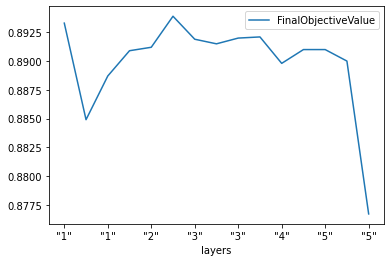

In [54]:
df.loc[
    :, ['FinalObjectiveValue', 'layers']
].set_index('layers').sort_index().plot()